In [1]:
import numpy as np
import multiprocess as mp
import statsmodels.stats.api as sms
from math import ceil
#from tqdm import tqdm

In [2]:
from src.bootstrap import bootstrap_ci
from src.perm_test import search
from src.utils import partition

---

In [3]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.CompareMeans.tconfint_diff.html
def tconfint(alpha, x1, x2, pooled=True, alternative="two-sided"):
    cm = sms.CompareMeans(sms.DescrStatsW(x1), sms.DescrStatsW(x2))
    return cm.tconfint_diff(alpha, alternative, usevar="pooled" if pooled else "unequal")

In [4]:
def passToThread(batch_start, batch_size, two_sided=True, pooled=True, method="permutation", alpha=0.05):

    def invert_test(batch_idx, alternative, method="permutation"):
        x1, x2 = x1s[batch_idx], x2s[batch_idx]
        if method == "t":
            lower, upper = tconfint(alpha, x1, x2, pooled, alternative)
            return lower, upper
        
        t99 = tconfint(0.001, x1, x2, pooled, alternative)
        t90 = tconfint(0.20, x1, x2, pooled, alternative)        
        lower, upper = -np.inf, np.inf
        if alternative != "smaller":
            lower = search(x1, x2, partitions, t99[0], t90[0], pooled=pooled, alternative=alternative)
        if alternative != "larger":
            upper = search(x1, x2, partitions, t90[1], t99[1], pooled=pooled, alternative=alternative)
        return lower, upper

    n_captured = n_error = 0
    for i in range(batch_start, batch_start + batch_size):
        try:
            if two_sided:
                lower, upper = invert_test(i, "two-sided", method)
            else:
                lower1, upper1 = invert_test(i, "smaller", method)
                lower2, upper2 = invert_test(i, "larger", method)
                lower, upper = max(lower1, lower2), min(upper1, upper2)
        except AssertionError:
            n_error += 1
            continue
        n_captured += (lower <= delta_true) * (delta_true <= upper)
    return n_captured, n_error

In [5]:
def simulate(two_sided=True, pooled=True, method="permutation"):
    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap(passToThread,\
                           [(i * batch_size, batch_size, two_sided, pooled, method) for i in range(n_batches)])
    pool.close()
    pool.join()
    results = np.array(results).sum(axis=0)
    if results[1]:
        return None
    
    return results[0] / total

---

In [6]:
total = 128
batch_size = mp.cpu_count()
n_batches = ceil(total/batch_size)

In [7]:
n1, n2 = 12, 8
partitions = partition(n1, n2)
partitions

array([[ 0,  1,  2, ..., 17, 18, 19],
       [ 0,  1,  2, ..., 17, 18, 19],
       [ 0,  1,  2, ..., 17, 18, 19],
       ...,
       [ 7,  8, 10, ...,  5,  6,  9],
       [ 7,  9, 10, ...,  5,  6,  8],
       [ 8,  9, 10, ...,  5,  6,  7]])

In [8]:
np.random.seed(123)
gammas = np.random.randint(1, 11, (3,2,2))

In [10]:
coverages = [[] for _ in range(8)]
i = 0
for g in gammas:
    np.random.seed(123)
    # global variables
    x1s = np.random.gamma(g[0,0], g[0,1], (total, n1))
    x2s = np.random.gamma(g[1,0], g[1,1], (total, n2))
    delta_true = (g[0,0] * g[0,1]) - (g[1,0]*g[1,1])  # true mean difference

    print("gamma1:", g[0], "gamma2:", g[1])
    for two_sided in [True, False]:
        for pooled in [True, False]:
            for method in ["permutation", "t"]:
                print(f"two_sided: {two_sided}, pooled: {pooled}, method: {method}")
                coverages[i].append(simulate(two_sided, pooled, method))
                i += 1
    print("---")
    i = 0

gamma1: [3 3] gamma2: [7 2]
two_sided: True, pooled: True, method: permutation
two_sided: True, pooled: True, method: t
two_sided: True, pooled: False, method: permutation
two_sided: True, pooled: False, method: t
two_sided: False, pooled: True, method: permutation
two_sided: False, pooled: True, method: t
two_sided: False, pooled: False, method: permutation
two_sided: False, pooled: False, method: t
---
gamma1: [ 4 10] gamma2: [7 2]
two_sided: True, pooled: True, method: permutation
two_sided: True, pooled: True, method: t
two_sided: True, pooled: False, method: permutation
two_sided: True, pooled: False, method: t
two_sided: False, pooled: True, method: permutation
two_sided: False, pooled: True, method: t
two_sided: False, pooled: False, method: permutation
two_sided: False, pooled: False, method: t
---
gamma1: [1 2] gamma2: [10  1]
two_sided: True, pooled: True, method: permutation
two_sided: True, pooled: True, method: t
two_sided: True, pooled: False, method: permutation
two_side

In [11]:
coverages

[[0.984375, 0.984375, 0.9765625],
 [0.953125, 0.96875, 0.9453125],
 [0.984375, 0.984375, 1.0],
 [0.953125, 0.96875, 0.9609375],
 [0.9765625, 0.984375, 0.9375],
 [0.9453125, 0.9609375, 0.84375],
 [0.9609375, 0.953125, 0.9296875],
 [0.9375, 0.9296875, 0.890625]]

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

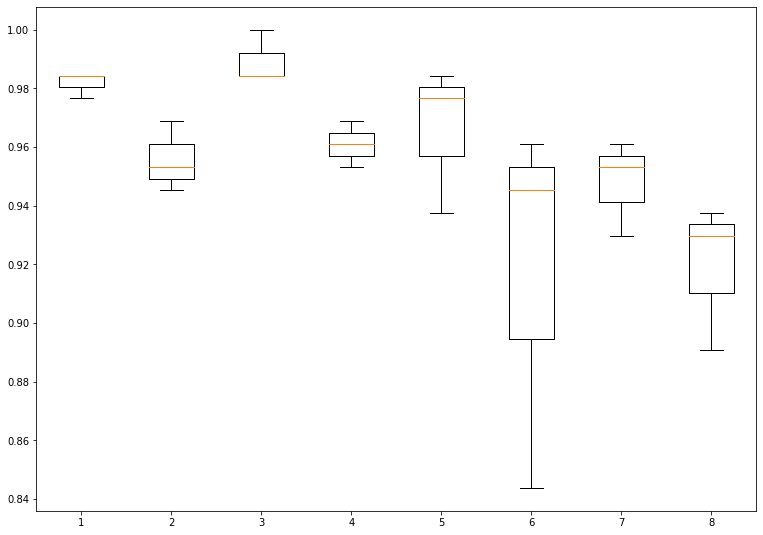

In [13]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(coverages)